In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [2]:
df = pd.read_csv('DATA.csv', index_col=0)
df['expiration_C']=pd.to_datetime(df['expiration_C'])

In [3]:
nasdaq = pd.read_csv('NASDAQ.csv')
nasdaq['Date']=pd.to_datetime(nasdaq['Date'])

In [4]:
newdf = pd.merge(df, nasdaq, how='left', left_on='expiration_C', right_on='Date')

In [8]:
newdf['pnl_long_Call'] =  np.maximum(newdf['Close/Last']-newdf['strike'],0)-(newdf['bid_1545_C']+newdf['ask_1545_C'])/2
newdf['pnl_long_Put'] =  np.maximum(newdf['strike']-newdf['Close/Last'],0)-(newdf['bid_1545_P']+newdf['ask_1545_P'])/2
newdf['pnl_short_Call'] = - np.maximum(newdf['Close/Last']-newdf['strike'],0) + (newdf['bid_1545_C']+newdf['ask_1545_C'])/2
newdf['pnl_short_Put'] =  - np.maximum(newdf['strike']-newdf['Close/Last'],0) + (newdf['bid_1545_P']+newdf['ask_1545_P'])/2

In [9]:
newdf[['quote_date', 'Close/Last', 'strike', 'bid_1545_C', 'ask_1545_C','bid_1545_P', 'ask_1545_P', 'pnl_long_Call', 'pnl_long_Put', 'pnl_short_Call', 'pnl_short_Put']].head()

,quote_date,Close/Last,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,pnl_long_Call,pnl_long_Put,pnl_short_Call,pnl_short_Put
0,2018-01-12,6412.68,5400.0,1347.0,1368.3,0.05,3.1,-344.97,-1.575,344.97,1.575
1,2018-01-12,6412.68,5500.0,1248.0,1269.0,0.25,3.7,-345.82,-1.975,345.82,1.975
2,2018-01-12,6412.68,5600.0,1151.6,1165.9,0.65,4.2,-346.07,-2.425,346.07,2.425
3,2018-01-12,6412.68,5700.0,1052.4,1066.7,1.70,4.3,-346.87,-3.000,346.87,3.000
4,2018-01-12,6412.68,5800.0,953.1,967.4,2.40,5.1,-347.57,-3.750,347.57,3.750


In [10]:
# get 28-day vol of NDX 100
vols = []
quote_dates = newdf['quote_date'].unique()
expirations = newdf['expiration_C'].unique()
for i in range(len(quote_dates)):
    q = quote_dates[i]
    e = expirations[i]
    NDX = nasdaq[(nasdaq['Date'] >= q) & (nasdaq['Date'] <= e)]
    vols.append(NDX['Close/Last'].std())

monthly_vol = pd.DataFrame({'quote_date' : quote_dates, 'vol' : vols})
newdf = pd.merge(newdf, monthly_vol, on = 'quote_date', how = 'left')

In [11]:
# define ajusted strike as (strike - implied forward) / vol
newdf['vol_adj_strike'] = (newdf['strike']-newdf['implied_S_x']) / newdf['vol']

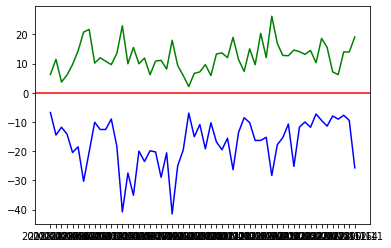

In [12]:
def adj_strike_min(group):
    return group['vol_adj_strike'].min() # smallest adj strike on a given date

def adj_strike_max(group):
    return group['vol_adj_strike'].max() # largest adj strike on a given date

low_bound = newdf.groupby("quote_date").apply(adj_strike_min)
high_bound = newdf.groupby("quote_date").apply(adj_strike_max)

fig, ax1 = plt.subplots()
plt.plot(low_bound, label="Minimum Strike", color='b')
plt.plot(high_bound, label="Maximum Strike", color='g')
plt.axhline(0, label="NDX", color='r')
# ax1.set_xlabel('Quote Date')
# ax1.set_ylabel('Strike Price and NDX', color='k')
# ax1.tick_params(axis='y', labelcolor='k')
# ax1.legend(loc='upper left')
# # Create a secondary y-axis for the bar graph
# ax2 = ax1.twinx()
# # Plot the bar graph on the secondary y-axis
# ax2.bar(newdf.groupby("quote_date").apply(lambda x: x.name), 
#         newdf.groupby("quote_date").apply(group_length), 
#         label="Number of Strikes", color='orange', alpha=0.5, width=20)

# ax2.set_ylabel('Number of Strikes', color='k')
# ax2.tick_params(axis='y', labelcolor='k')
# ax2.legend(loc='upper right')
# plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()

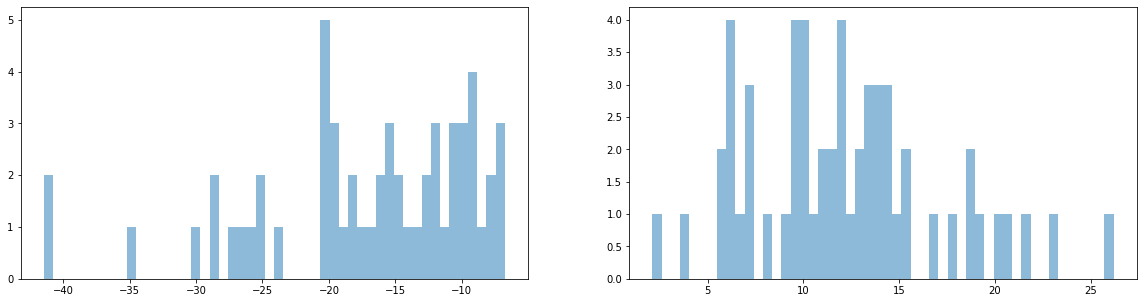

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
ax[0].hist(low_bound, bins=50, alpha=0.5, label='Minimum Strike')
ax[1].hist(high_bound, bins=50, alpha=0.5, label='Maximum Strike')
plt.show()

In [29]:
# option 1: pick all possibles strikes
high = np.max(high_bound)
low = np.min(low_bound)
length = newdf.groupby("quote_date").size().max()
points = np.linspace(low, high, length)
print('high:', high, 'low:', low, 'interval length:', (high-low)/(length-1))    

high: 26.190931985187053 low: -41.4686601592959 interval length: 0.19611475983908103


In [16]:
# # option 2: pick a selected range of strikes
# high = 15
# low = -20
# length = 141
# points = np.linspace(low, high, length)
# print('interval length:', (high-low)/(length-1))

interval length: 0.25


In [30]:
# eliminate out of range strikes
newdf = newdf[(newdf['vol_adj_strike'] >= low) & (newdf['vol_adj_strike'] <= high)]

In [31]:
# find the nearest strike data for each point

pnl_2 = pd.merge(pd.DataFrame({'quote_date': newdf['quote_date'].unique()}), pd.DataFrame({'no': list(range(1,length+1)),'strike': points}), how='cross')

pnl_2[['vol_adj_strike', 'pnl_long_Call','pnl_long_Put','pnl_short_Call','pnl_short_Put']] = [0,0,0,0,0]

for index, row in pnl_2.iterrows():
    selection = newdf[(newdf['quote_date'] == row['quote_date'])].iloc[(newdf[(newdf['quote_date'] == row['quote_date'])]['vol_adj_strike'] - row['strike']).abs().argsort()[:1]]    
    if abs(selection['vol_adj_strike'].values[0] - row['strike'])<=(high-low)/(length-1):
        pnl_2.at[index, 'vol_adj_strike'] = selection['vol_adj_strike'].values[0]
        pnl_2.at[index, 'pnl_long_Call'] = selection['pnl_long_Call'].values[0]
        pnl_2.at[index, 'pnl_long_Put'] = selection['pnl_long_Put'].values[0]
        pnl_2.at[index, 'pnl_short_Call'] = selection['pnl_short_Call'].values[0]
        pnl_2.at[index, 'pnl_short_Put'] = selection['pnl_short_Put'].values[0]

In [32]:
call_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_long_Call')
put_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_long_Put')
call_S_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_short_Call')
put_S_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_short_Put') 
call_PNL.columns = [f"{col}_C" for col in call_PNL.columns]
put_PNL.columns = [f"{col}_P" for col in put_PNL.columns]
call_S_PNL.columns = [f"{col}_C_S" for col in call_S_PNL.columns]
put_S_PNL.columns = [f"{col}_P_S" for col in put_S_PNL.columns]
option_PNL = pd.merge(call_PNL , put_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , call_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , put_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
# option_PNL

In [34]:
option_PNL

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,11_C,12_C,13_C,14_C,15_C,16_C,17_C,18_C,19_C,20_C,21_C,22_C,23_C,24_C,25_C,26_C,27_C,28_C,29_C,30_C,31_C,32_C,33_C,34_C,35_C,36_C,37_C,38_C,39_C,40_C,41_C,42_C,43_C,44_C,45_C,46_C,47_C,48_C,49_C,50_C,51_C,52_C,53_C,54_C,55_C,56_C,57_C,58_C,59_C,60_C,61_C,62_C,63_C,64_C,65_C,66_C,67_C,68_C,69_C,70_C,71_C,72_C,73_C,74_C,75_C,76_C,77_C,78_C,79_C,80_C,81_C,82_C,83_C,84_C,85_C,86_C,87_C,88_C,89_C,90_C,91_C,92_C,93_C,94_C,95_C,96_C,97_C,98_C,99_C,100_C,101_C,102_C,103_C,104_C,105_C,106_C,107_C,108_C,109_C,110_C,111_C,112_C,113_C,114_C,115_C,116_C,117_C,118_C,119_C,120_C,121_C,122_C,123_C,124_C,125_C,126_C,127_C,128_C,129_C,130_C,131_C,132_C,133_C,134_C,135_C,136_C,137_C,138_C,139_C,140_C,141_C,142_C,143_C,144_C,145_C,146_C,147_C,148_C,149_C,150_C,151_C,152_C,153_C,154_C,155_C,156_C,157_C,158_C,159_C,160_C,161_C,162_C,163_C,164_C,165_C,166_C,167_C,168_C,169_C,170_C,171_C,172_C,173_C,174_C,175_C,176_C,177_C,178_C,179_C,180_C,181_C,182_C,183_C,184_C,185_C,186_C,187_C,188_C,189_C,190_C,191_C,192_C,193_C,194_C,195_C,196_C,197_C,198_C,199_C,200_C,201_C,202_C,203_C,204_C,205_C,206_C,207_C,208_C,209_C,210_C,211_C,212_C,213_C,214_C,215_C,216_C,217_C,218_C,219_C,220_C,221_C,222_C,223_C,224_C,225_C,226_C,227_C,228_C,229_C,230_C,231_C,232_C,233_C,234_C,235_C,236_C,237_C,238_C,239_C,240_C,241_C,242_C,243_C,244_C,245_C,246_C,247_C,248_C,249_C,250_C,...,97_P_S,98_P_S,99_P_S,100_P_S,101_P_S,102_P_S,103_P_S,104_P_S,105_P_S,106_P_S,107_P_S,108_P_S,109_P_S,110_P_S,111_P_S,112_P_S,113_P_S,114_P_S,115_P_S,116_P_S,117_P_S,118_P_S,119_P_S,120_P_S,121_P_S,122_P_S,123_P_S,124_P_S,125_P_S,126_P_S,127_P_S,128_P_S,129_P_S,130_P_S,131_P_S,132_P_S,133_P_S,134_P_S,135_P_S,136_P_S,137_P_S,138_P_S,139_P_S,140_P_S,141_P_S,142_P_S,143_P_S,144_P_S,145_P_S,146_P_S,147_P_S,148_P_S,149_P_S,150_P_S,151_P_S,152_P_S,153_P_S,154_P_S,155_P_S,156_P_S,157_P_S,158_P_S,159_P_S,160_P_S,161_P_S,162_P_S,163_P_S,164_P_S,165_P_S,166_P_S,167_P_S,168_P_S,169_P_S,170_P_S,171_P_S,172_P_S,173_P_S,174_P_S,175_P_S,176_P_S,177_P_S,178_P_S,179_P_S,180_P_S,181_P_S,182_P_S,183_P_S,184_P_S,185_P_S,186_P_S,187_P_S,188_P_S,189_P_S,190_P_S,191_P_S,192_P_S,193_P_S,194_P_S,195_P_S,196_P_S,197_P_S,198_P_S,199_P_S,200_P_S,201_P_S,202_P_S,203_P_S,204_P_S,205_P_S,206_P_S,207_P_S,208_P_S,209_P_S,210_P_S,211_P_S,212_P_S,213_P_S,214_P_S,215_P_S,216_P_S,217_P_S,218_P_S,219_P_S,220_P_S,221_P_S,222_P_S,223_P_S,224_P_S,225_P_S,226_P_S,227_P_S,228_P_S,229_P_S,230_P_S,231_P_S,232_P_S,233_P_S,234_P_S,235_P_S,236_P_S,237_P_S,238_P_S,239_P_S,240_P_S,241_P_S,242_P_S,243_P_S,244_P_S,245_P_S,246_P_S,247_P_S,248_P_S,249_P_S,250_P_S,251_P_S,252_P_S,253_P_S,254_P_S,255_P_S,256_P_S,257_P_S,258_P_S,259_P_S,260_P_S,261_P_S,262_P_S,263_P_S,264_P_S,265_P_S,266_P_S,267_P_S,268_P_S,269_P_S,270_P_S,271_P_S,272_P_S,273_P_S,274_P_S,275_P_S,276_P_S,277_P_S,278_P_S,279_P_S,280_P_S,281_P_S,282_P_S,283_P_S,284_P_S,285_P_S,286_P_S,287_P_S,288_P_S,289_P_S,290_P_S,291_P_S,292_P_S,293_P_S,294_P_S,295_P_S,296_P_S,297_P_S,298_P_S,299_P_S,300_P_S,301_P_S,302_P_S,303_P_S,304_P_S,305_P_S,306_P_S,307_P_S,308_P_S,309_P_S,310_P_S,311_P_S,312_P_S,313_P_S,314_P_S,315_P_S,316_P_S,317_P_S,318_P_S,319_P_S,320_P_S,321_P_S,322_P_S,323_P_S,324_P_S,325_P_S,326_P_S,327_P_S,328_P_S,329_P_S,330_P_S,331_P_S,332_P_S,333_P_S,334_P_S,335_P_S,336_P_S,337_P_S,338_P_S,339_P_S,340_P_S,341_P_S,342_P_S,343_P_S,344_P_S,345_P_S,346_P_S
quote_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [43]:
# pip install cvxpy

constraint $\gamma$<->$L$:

$w^T w\leq L^2/d \iff L<\frac{\sqrt{d}||\mu||}{\gamma\sigma_\infty}$

find $\sigma_\infty$ and $||\mu||$


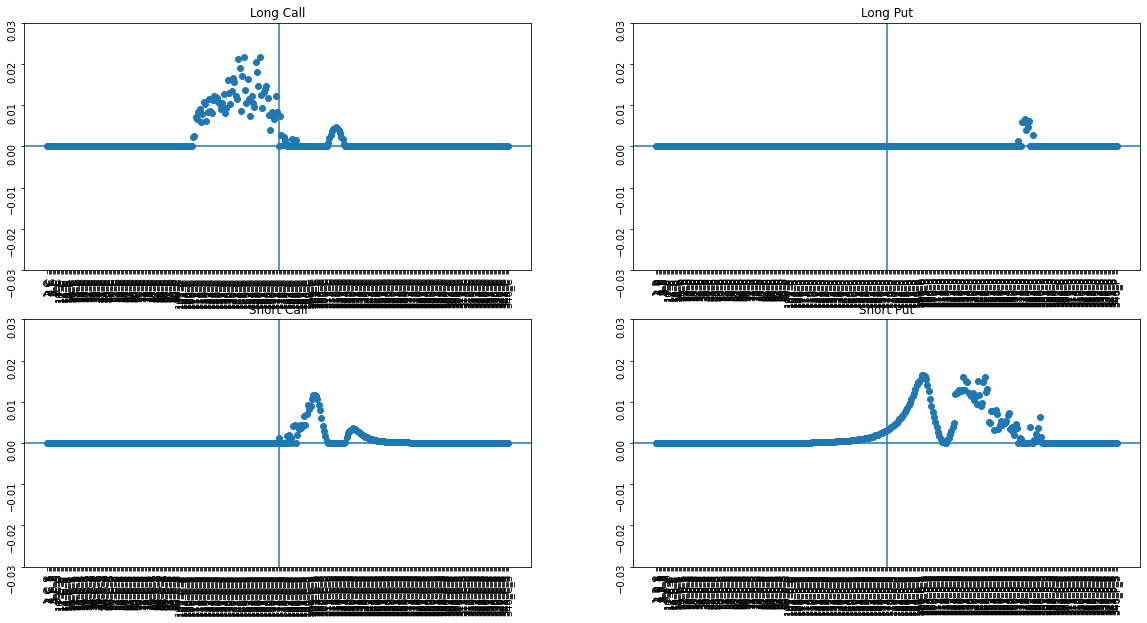

In [38]:
import numpy as np
import cvxpy as cp

# Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# # mu as a random n-vector, would be substituded by the expected return
mu = option_PNL.mean().to_numpy()
n = len(mu)
Sigma = option_PNL.cov()
gamma = 0.0005
lam = 10000000
Sigma_1 = Sigma + lam * np.identity(n)
Sigma_1 = cp.psd_wrap(Sigma_1)
# constraints 
# h=0_n, A=1_n, b=1
# Gw >= h equiv to w_i>=0 for all i
# Aw = b equiv to sum(w_i)=1
h = np.zeros(n)
A = np.ones(n)
b = 1

# Define and solve the CVXPY problem.
w = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
            [
                w >= h,
                # A.T @ w == b
                ]
                )
prob.solve(solver = cp.OSQP, verbose=False, eps_abs=1e-20)

# # Print result.
# print("\nThe optimal value is", prob.value)
# print("A solution w is")
# print(w.value)

# graph weights vs strike, see if at 1 it is a peak/valley

m = n//4

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
# plt.grid()
ax[0][0].scatter(option_PNL.columns[:m], w.value[:m])
ax[0][0].axhline(y=0)
ax[0][0].axvline(x=m//2)
ax[0][0].tick_params(labelrotation=90)
ax[0][0].set_ylim(-0.03,0.03)
ax[0][0].set_title('Long Call')

ax[0][1].scatter(option_PNL.columns[m:2*m], w.value[m:2*m])
ax[0][1].tick_params(labelrotation=90)
ax[0][1].axhline(y=0)
ax[0][1].axvline(x=m//2)
ax[0][1].set_ylim(-0.03,0.03)
ax[0][1].set_title('Long Put')

ax[1][0].scatter(option_PNL.columns[2*m:3*m], w.value[2*m:3*m])
ax[1][0].tick_params(labelrotation=90)
ax[1][0].axhline(y=0)
ax[1][0].axvline(x=m//2)
ax[1][0].set_ylim(-0.03,0.03)
ax[1][0].set_title('Short Call')

ax[1][1].scatter(option_PNL.columns[3*m:], w.value[3*m:])
ax[1][1].tick_params(labelrotation=90)
ax[1][1].axhline(y=0)
ax[1][1].axvline(x=m//2)
ax[1][1].set_ylim(-0.03,0.03)
ax[1][1].set_title('Short Put')

plt.show()

In [39]:
print('profit:', w.value.T @ mu)
print('standard deviation:', np.sqrt(w.value.T @ Sigma @ w.value))

profit: 155.7643456378467
standard deviation: 333.6769663320425


In [40]:
# check if there exist long and short positions for the same strike simulataneously
print((abs(w.value[:m]*w.value[2*m:3*m])>1e-10).sum())
print((abs(w.value[m:2*m]*w.value[3*m:])>1e-10).sum())

0
0


In [41]:
nasdaq_1 = nasdaq[nasdaq['Date'].isin(quote_dates)]
nasdaq_1.set_index('Date', inplace=True)

In [42]:
portfolio = np.cumsum(option_PNL@w.value.T)
portfolio.index = pd.to_datetime(portfolio.index)

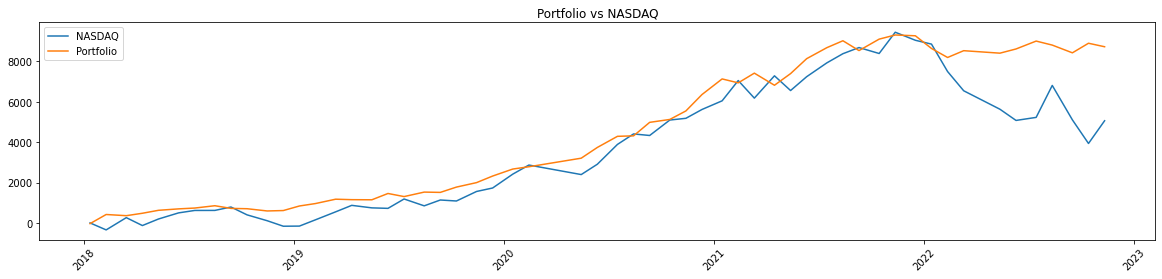

In [43]:
plt.figure(figsize=(20,4))
plt.plot(nasdaq_1['Close/Last']-nasdaq_1.loc['2018-01-12', ['Close/Last']].values[0], label='NASDAQ')
plt.plot(portfolio, label = 'Portfolio')
plt.xticks(rotation=45)
plt.legend()
plt.title('Portfolio vs NASDAQ')
plt.show()

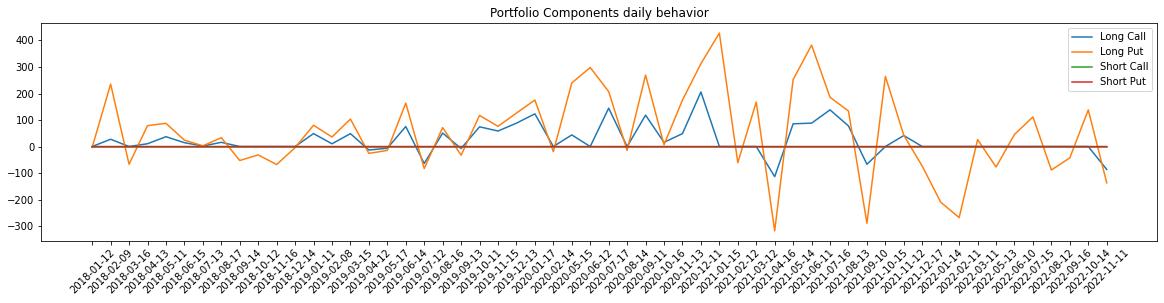

In [44]:
plt.figure(figsize=(20,4))
plt.plot(option_PNL.iloc[:,:141*1]@w.value[:141*1].T, label='Long Call')
plt.plot(option_PNL.iloc[:,141*1:141*2]@w.value[141*1:141*2].T, label='Long Put')
plt.plot(option_PNL.iloc[:,141*2:141*3]@w.value[141*2:141*3].T, label='Short Call')
plt.plot(option_PNL.iloc[:,141*3:141*4]@w.value[141*3:141*4].T,label = 'Short Put')
plt.xticks(rotation=45)
plt.legend()
plt.title('Portfolio Components daily behavior')
plt.show()


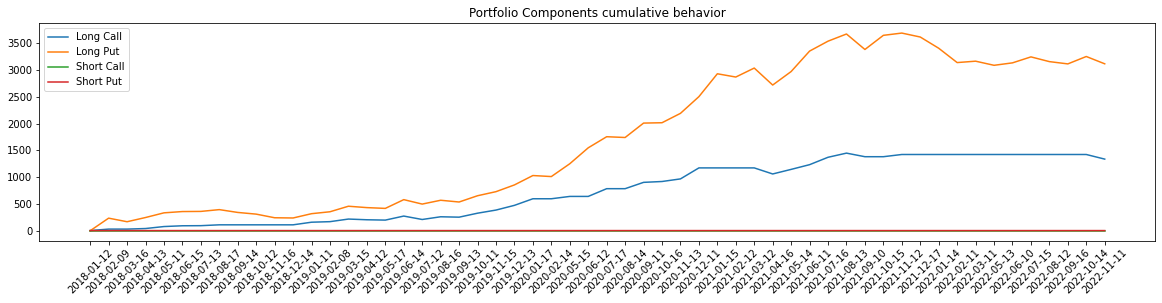

In [45]:
plt.figure(figsize=(20,4))
plt.plot(np.cumsum(option_PNL.iloc[:,:141*1]@w.value[:141*1].T), label='Long Call')
plt.plot(np.cumsum(option_PNL.iloc[:,141*1:141*2]@w.value[141*1:141*2].T), label='Long Put')
plt.plot(np.cumsum(option_PNL.iloc[:,141*2:141*3]@w.value[141*2:141*3].T), label='Short Call')  
plt.plot(np.cumsum(option_PNL.iloc[:,141*3:141*4]@w.value[141*3:141*4].T),label = 'Short Put')
plt.xticks(rotation=45)
plt.legend()
plt.title('Portfolio Components cumulative behavior')
plt.show()


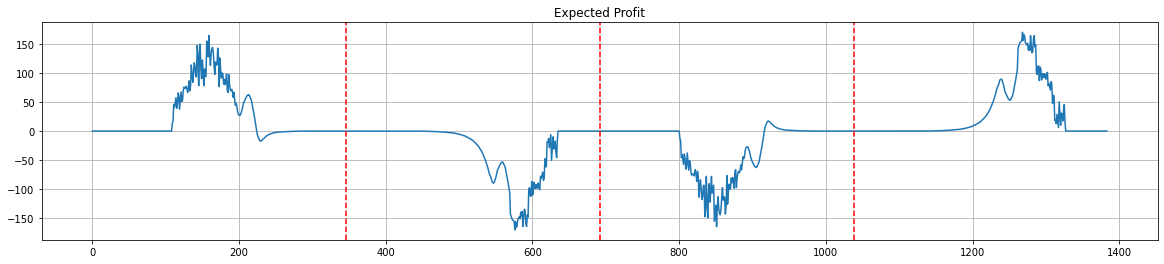

In [47]:
plt.figure(figsize=(20,4))
plt.grid()
plt.plot(mu)
plt.axvline(x=len(mu)//4, linestyle = 'dashed', color='r')
plt.axvline(x=len(mu)//2, linestyle = 'dashed', color='r')
plt.axvline(x=len(mu)*3//4, linestyle = 'dashed', color='r')
plt.title('Expected Profit')
plt.show()


In [131]:
std_strikes = pd.read_csv('std_strikes.csv', index_col=0)

In [132]:
std_strikes

,quote_date,expiration,std_strike,adj_strike,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,vol
0,2018-01-12,2018-02-09,-20.00,-6.768575,2018-02-09,5400.0,1347.00,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,199.483861
1,2018-01-12,2018-02-09,-19.75,-6.768575,2018-02-09,5400.0,1347.00,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,199.483861
2,2018-01-12,2018-02-09,-19.50,-6.768575,2018-02-09,5400.0,1347.00,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,199.483861
3,2018-01-12,2018-02-09,-19.25,-6.768575,2018-02-09,5400.0,1347.00,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,199.483861
4,2018-01-12,2018-02-09,-19.00,-6.768575,2018-02-09,5400.0,1347.00,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,199.483861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8314,2022-11-11,2022-12-09,14.00,13.702703,2022-12-09,14100.0,1.55,4.3,2243.00,2267.8,2022-11-11,0.0371,11804.786584,-2295.213416,11805.333099,167.500778
8315,2022-11-11,2022-12-09,14.25,14.300032,2022-12-09,14200.0,1.05,3.8,2342.20,2367.1,2022-11-11,0.0371,11804.733475,-2395.266525,11805.333099,167.500778
8316,2022-11-11,2022-12-09,14.50,14.300032,2022-12-09,14200.0,1.05,3.8,2342.20,2367.1,2022-11-11,0.0371,11804.733475,-2395.266525,11805.333099,167.500778
8317,2022-11-11,2022-12-09,14.75,14.898406,2022-12-09,14300.0,0.70,3.4,2442.00,2466.4,2022-11-11,0.0371,11804.505366,-2495.494634,11805.333099,167.500778


In [352]:
pip install coptpy

     |████████████████████████████████| 15.0 MB 547 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [86]:
import coptpy 
# Define and solve the CVXPY problem.
w = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
            [
                w >= h,
                # A.T @ w == b
                ]
                )
prob.solve(solver =cp.COPT , verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 11 03:51:29 PM: Your problem has 564 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 11 03:51:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 03:51:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 03:51:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 03:51:29 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 11 03:51:29 PM: Compiling problem (target solver=COPT).
(CV

-79.61989241585889

In [340]:
m

66

0
0


In [63]:
import numpy as np
import cvxpy as cp

# Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# # mu as a random n-vector, would be substituded by the expected return
for lam in [1000,10000,100000,1000000,10000000]:
  for gamma in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]:
    print('\n')
    print(f'lambda = {lam}, gamma = {gamma}')
    mu = pnl_1.mean().to_numpy()
    n = len(mu)
    Sigma = pnl_1.cov()
    # gamma = 1.
    # lam = 500.
    Sigma_1 = Sigma + lam * np.identity(n)
    Sigma_1 = cp.psd_wrap(Sigma_1)
    # constraints 
    # h=0_n, A=1_n, b=1
    # Gw >= h equiv to w_i>=0 for all i
    # Aw = b equiv to sum(w_i)=1
    h = np.zeros(n)
    A = np.ones(n)
    b = 1

    # Define and solve the CVXPY problem.
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
                    [
                        w >= h,
                      A.T @ w == b
                      ]
                      )
    prob.solve()

    print(np.sqrt(w.value.T @ Sigma @ w.value))
    # # Print result.
    # print("\nThe optimal value is", prob.value)
    # print("A solution w is")
    # print(w.value)

    # graph weights vs strike, see if at 1 it is a peak/valley
    
    # fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
    # ax[0][0].scatter(pnl_1.columns[:67], w.value[:67])
    # ax[0][0].tick_params(labelrotation=90)

    # ax[0][1].scatter(pnl_1.columns[67:134], w.value[67:134])
    # ax[0][1].tick_params(labelrotation=90)

    # ax[1][0].scatter(pnl_1.columns[134:201], w.value[134:201])
    # ax[1][0].tick_params(labelrotation=90)

    # ax[1][1].scatter(pnl_1.columns[201:], w.value[201:])
    # ax[1][1].tick_params(labelrotation=90)
    # plt.show()



lambda = 1000, gamma = 0.0001
654.5844365966191


lambda = 1000, gamma = 0.001
158.32492184194135


lambda = 1000, gamma = 0.01
30.41228355129159


lambda = 1000, gamma = 0.1
7.428637382764107


lambda = 1000, gamma = 1
1.5371501026023708


lambda = 1000, gamma = 10
0.861162706001084


lambda = 1000, gamma = 100
0.8192633495667592


lambda = 1000, gamma = 1000
0.8155144123076806


lambda = 1000, gamma = 10000
0.8151441656136845


lambda = 1000, gamma = 100000
0.8151071876488772


lambda = 10000, gamma = 0.0001
653.8570257096211


lambda = 10000, gamma = 0.001
160.5704696211674


lambda = 10000, gamma = 0.01
28.706331553750648


lambda = 10000, gamma = 0.1
6.220470871104922


lambda = 10000, gamma = 1
1.5823083652704184


lambda = 10000, gamma = 10
1.2838737712673198


lambda = 10000, gamma = 100
1.2637016482503771


lambda = 10000, gamma = 1000
1.2618020142519857


lambda = 10000, gamma = 10000
1.261613246833843


lambda = 10000, gamma = 100000
1.2615943820713869


lambda = 100000, g

In [ ]:
# Plot trade-off curve.

%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [68]:
mu.T@w.value

23.886867947468414

In [67]:
np.sqrt(w.value.T @ Sigma @ w.value)

123.85945986799972

In [20]:
# import numpy as np
# import cvxpy as cp

# # Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# # # mu as a random n-vector, would be substituded by the expected return


# mu = pnl_1.mean().to_numpy()
# n = len(mu)
# Sigma = pnl_1.cov()
# gamma = 1.
# lam = 1.
# Sigma_1 = Sigma + lam * np.identity(n)
# Sigma_1 = cp.psd_wrap(Sigma_1)
# # constraints 
# # h=0_n, A=1_n, b=1
# # Gw >= h equiv to w_i>=0 for all i
# # Aw = b equiv to sum(w_i)=1
# h = np.zeros(n)
# A = np.ones(n)
# b = 1

# # Define and solve the CVXPY problem.
# w = cp.Variable(n)
# prob = cp.Problem(cp.Minimize((mu.T @ w)/ (cp.quad_form(w, Sigma)) - gamma * cp.quad_form(w,np.identity(n))),
#             [
#                 w >= h,
#                 A.T @ w == b
#                 ]
#                 )
# prob.solve()

# # # Print result.
# # print("\nThe optimal value is", prob.value)
# # print("A solution w is")
# # print(w.value)

# # graph weights vs strike, see if at 1 it is a peak/valley

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
# ax[0][0].scatter(pnl_1.columns[:67], w.value[:67])
# ax[0][0].tick_params(labelrotation=90)

# ax[0][1].scatter(pnl_1.columns[67:134], w.value[67:134])
# ax[0][1].tick_params(labelrotation=90)

# ax[1][0].scatter(pnl_1.columns[134:201], w.value[134:201])
# ax[1][0].tick_params(labelrotation=90)

# ax[1][1].scatter(pnl_1.columns[201:], w.value[201:])
# ax[1][1].tick_params(labelrotation=90)
# plt.show()

In [284]:
pnl_1.columns

Index(['1_C', '2_C', '3_C', '4_C', '5_C', '6_C', '7_C', '8_C', '9_C', '10_C',
       ...
       '58_P', '59_P', '60_P', '61_P', '62_P', '63_P', '64_P', '65_P', '66_P', '67_P'], dtype='object', length=134)

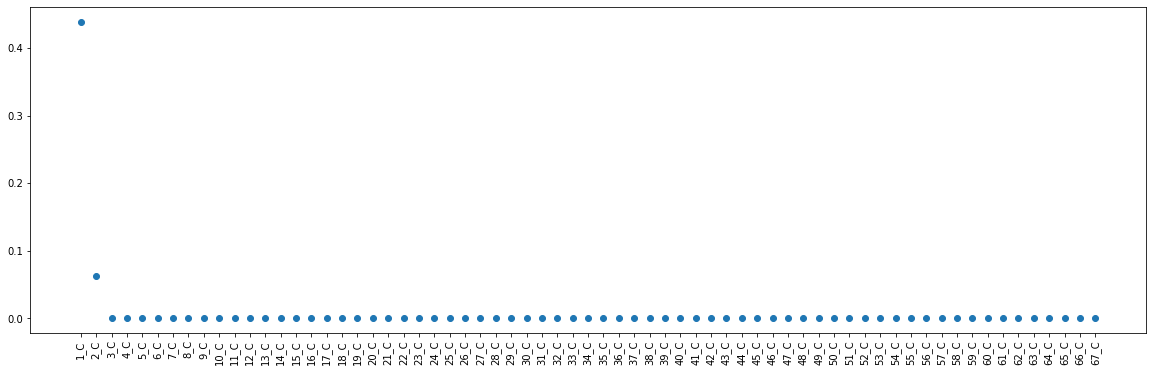

In [293]:
# graph weights vs strike, see if at 1 it is a peak/valley
plt.figure(figsize=(20,6))
plt.scatter(pnl_1.columns[:67], w.value[:67])
plt.xticks(rotation=90)
plt.show()

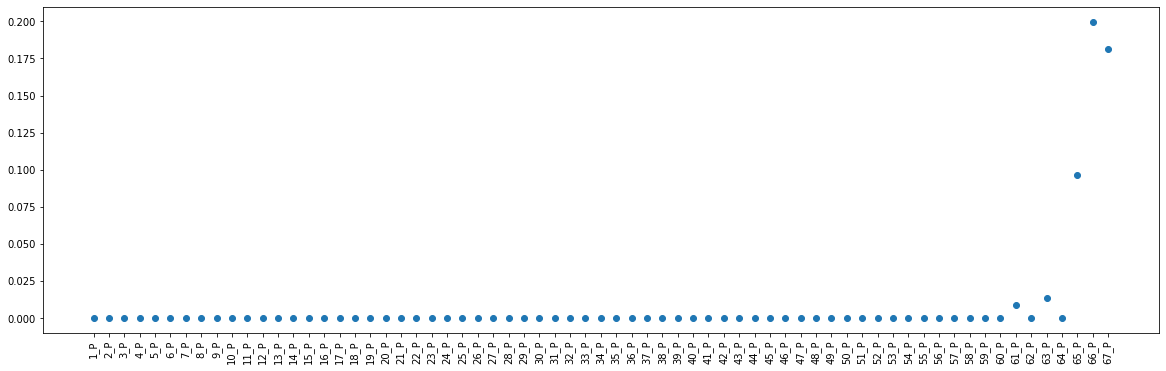

In [289]:
# graph weights vs strike, see if at 1 it is a peak/valley
plt.figure(figsize=(20,6))
plt.scatter(pnl_1.columns[67:], w.value[67:])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# uniformly draw 41 samples of strike_adj from each date
sample_size = 67
newdf_sampled = newdf.groupby('quote_date').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)
# rank the strike_adj within each date
newdf_sampled['strike_adj_rank'] = newdf_sampled.groupby('quote_date')['strike_adj'].rank()